[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat Jul 19 15:09:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 73.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-07-19 15:12:43--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-07-19 15:12:43 (85.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:01<00:00, 41.4MB/s]


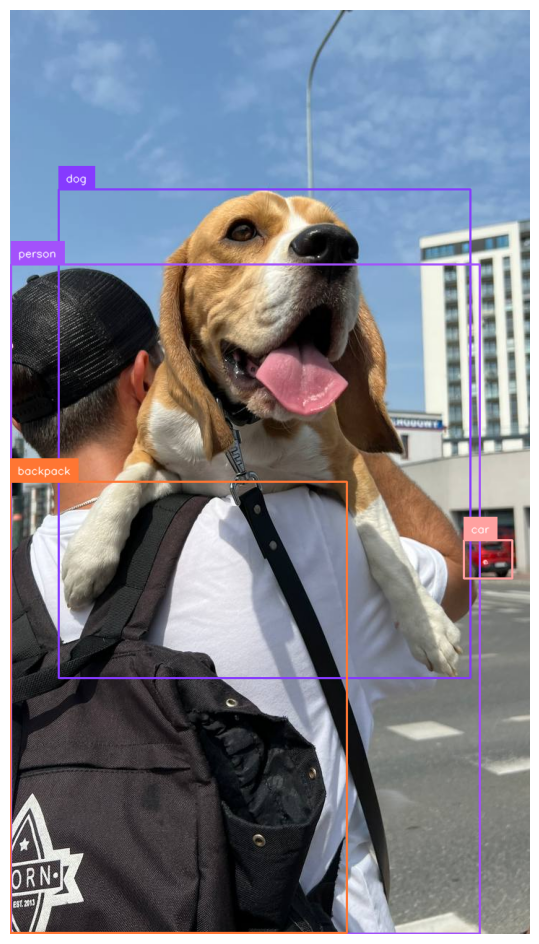

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import Roboflow
from roboflow import download_dataset

rf = Roboflow(api_key="Uj5MjQA12mDv8vICzSaL")
project = rf.workspace("riz-yak11").project("vehicles-q0x2v-71cst")
version = project.version(2)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vehicles-2 in yolov12:: 100%|██████████| 8128/8128 [00:02<00:00, 3753.12it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['bus', 'non-bus']

roboflow:
  workspace: riz-yak11
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12n.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=250, patience=20)

100%|██████████| 5.26M/5.26M [00:00<00:00, 57.4MB/s]


New https://pypi.org/project/ultralytics/8.3.168 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.pt, data=/content/vehicles-2/data.yaml, epochs=250, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 25.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /content/vehicles-2/train/labels... 2634 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2634/2634 [00:01<00:00, 2335.36it/s]

train: WARNING ⚠️ /content/vehicles-2/train/images/adit_mp4-1357_jpg.rf.ef4a9167aa1eec7d825f40796e857061.jpg: 2 duplicate labels removed
train: New cache created: /content/vehicles-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/vehicles-2/valid/labels... 966 images, 3 backgrounds, 0 corrupt: 100%|██████████| 966/966 [00:00<00:00, 1087.57it/s]

val: New cache created: /content/vehicles-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      4.07G      1.468      1.868      1.194        184        640: 100%|██████████| 165/165 [01:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


                   all        966      13450      0.416      0.435      0.421      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250       4.4G      1.383      1.051      1.143        169        640: 100%|██████████| 165/165 [01:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        966      13450      0.672      0.635      0.648      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      4.35G       1.39      1.009       1.15         87        640: 100%|██████████| 165/165 [01:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


                   all        966      13450      0.768      0.689      0.729      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      4.53G      1.371     0.9507      1.143        237        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


                   all        966      13450      0.767      0.679      0.713      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      4.37G      1.342     0.9011      1.139        175        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


                   all        966      13450      0.794      0.673      0.724       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      3.87G      1.322      0.859      1.129        197        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


                   all        966      13450      0.695      0.702      0.702       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      4.52G      1.302     0.8102      1.123        191        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


                   all        966      13450      0.667      0.635      0.678      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      4.05G      1.289     0.7916      1.122        140        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


                   all        966      13450      0.681      0.641      0.651      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      4.18G      1.279     0.7684      1.119        117        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


                   all        966      13450      0.736      0.738      0.724      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      4.27G      1.248     0.7444      1.108        162        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


                   all        966      13450      0.775      0.716      0.735      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      4.26G       1.27     0.7445       1.11        233        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        966      13450      0.801      0.715      0.751       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250       4.4G      1.258     0.7213      1.107        106        640: 100%|██████████| 165/165 [01:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        966      13450       0.77      0.732      0.768      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      4.39G      1.246     0.7119      1.109        156        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]

                   all        966      13450      0.741      0.747      0.789       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      4.47G      1.236     0.6987      1.103        168        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


                   all        966      13450      0.706      0.716      0.712      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      4.06G       1.23     0.7071      1.102        140        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        966      13450      0.772      0.711      0.723      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      4.09G      1.225     0.6902      1.099        236        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.788      0.753      0.768      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      4.39G      1.224     0.6818      1.097        132        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        966      13450        0.8      0.729      0.751      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      4.41G      1.208     0.6773      1.094        177        640: 100%|██████████| 165/165 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.782      0.744       0.76      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250       4.5G      1.194     0.6635      1.086        165        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450       0.78      0.752       0.78      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      4.18G      1.206     0.6662      1.094        215        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


                   all        966      13450      0.777      0.779      0.775      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      4.16G      1.187     0.6511      1.083         85        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.771      0.755      0.773        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      4.18G      1.199      0.653      1.094        172        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.804      0.716       0.75      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      4.23G      1.194     0.6466      1.089        231        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.803      0.746      0.766      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      4.19G      1.187     0.6395      1.084        281        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.803      0.775      0.787      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      4.53G      1.183     0.6369      1.087        207        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.807      0.757       0.78      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250       4.4G      1.182     0.6304      1.087        134        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]

                   all        966      13450      0.785      0.762       0.78      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      4.26G      1.159     0.6166      1.069        188        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.773      0.767      0.785      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250       4.4G      1.172     0.6308      1.076        210        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.783      0.785      0.801      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      4.17G      1.172     0.6208      1.082        170        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.809      0.751      0.788       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250       4.1G      1.161     0.6152      1.074        196        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.784      0.775        0.8      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      4.04G      1.164     0.6175      1.079        226        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.764      0.746      0.754      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      4.32G      1.157     0.6138      1.073        108        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450        0.8      0.756      0.797      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250       4.2G      1.152     0.6076      1.073        172        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.778      0.749      0.798      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      4.02G      1.156     0.6087      1.074        153        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.809      0.742      0.763      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      4.03G      1.148      0.601       1.07         95        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.782      0.751      0.782       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250         4G      1.161     0.6119      1.077        150        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.47it/s]

                   all        966      13450      0.812      0.763      0.773       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      4.55G      1.137     0.5991      1.067        123        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]

                   all        966      13450      0.809      0.752      0.772      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      4.22G      1.141     0.5965      1.068        224        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.798      0.752      0.784      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      4.24G      1.137     0.5926       1.06        199        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.807      0.765      0.784      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250         4G      1.144     0.5939      1.071        117        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450       0.81      0.762       0.79      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      4.05G      1.129     0.5865      1.065        155        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.804      0.776      0.791      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      4.24G      1.138     0.5878       1.07        114        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.807      0.771      0.776      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      4.22G      1.123      0.577      1.062        134        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.806      0.784      0.809      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      3.89G      1.127     0.5812       1.06        162        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.777       0.75       0.79      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      4.01G      1.123     0.5821      1.058        149        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.778      0.776      0.781      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250       4.2G      1.119     0.5764      1.056        126        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.793       0.78      0.787      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      4.09G      1.125     0.5733      1.065        271        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.836      0.781      0.798      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      4.36G      1.122     0.5749      1.062        172        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.809      0.784      0.793      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      4.48G      1.129     0.5782      1.063        140        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.807      0.767        0.8       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      4.02G      1.116     0.5754      1.061        231        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        966      13450      0.803      0.768        0.8      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      4.24G      1.114     0.5707      1.057        182        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


                   all        966      13450      0.782      0.765      0.771      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      4.05G      1.113     0.5687      1.053        155        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]

                   all        966      13450      0.797      0.767      0.773      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      4.22G      1.119     0.5684       1.06        193        640: 100%|██████████| 165/165 [01:02<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.787      0.776      0.786      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      4.14G      1.099     0.5583       1.05        232        640: 100%|██████████| 165/165 [01:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]

                   all        966      13450      0.794      0.798      0.801      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      3.96G      1.102     0.5557      1.057        119        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.802      0.794      0.804      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250         4G      1.108     0.5596      1.063        215        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.808      0.781      0.806      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      4.53G      1.097     0.5582      1.051        228        640: 100%|██████████| 165/165 [01:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.803      0.765      0.784      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      4.38G      1.089     0.5508      1.049        150        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]

                   all        966      13450      0.786      0.779      0.795      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      3.87G      1.096     0.5516      1.047        176        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.58it/s]

                   all        966      13450        0.8      0.789      0.784      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      4.07G      1.096     0.5526      1.054        163        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.798      0.782       0.78      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      4.17G      1.102     0.5545      1.055        262        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]

                   all        966      13450      0.801      0.782      0.797      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      4.13G      1.093     0.5534      1.053        137        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]

                   all        966      13450       0.79       0.79      0.804      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250       3.9G      1.097     0.5546       1.05        164        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.819      0.776      0.806      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      4.24G      1.081     0.5442      1.044        142        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.827      0.771      0.812      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      4.16G      1.097     0.5487      1.053        135        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.808      0.788      0.793      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      4.11G      1.078     0.5388      1.043        106        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.792      0.794      0.803      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      4.36G      1.077     0.5402      1.041        184        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450       0.81      0.781        0.8      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      4.06G      1.075     0.5344      1.042        196        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.806       0.78      0.779      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      4.06G      1.078     0.5393      1.046        131        640: 100%|██████████| 165/165 [01:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.804      0.775      0.801      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      4.22G      1.073     0.5349      1.046        177        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]

                   all        966      13450      0.811      0.766      0.799      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      4.19G      1.079     0.5371      1.048        208        640: 100%|██████████| 165/165 [01:17<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


                   all        966      13450      0.788      0.798      0.789      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250       4.2G      1.084     0.5405      1.051        223        640: 100%|██████████| 165/165 [01:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.793      0.782      0.782      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      4.27G      1.079      0.536      1.042        137        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.795      0.808      0.789      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      3.91G       1.07      0.529      1.041        174        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.799      0.782       0.79      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      4.15G      1.067     0.5314      1.033        143        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.819      0.775      0.785      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      4.05G      1.066      0.528      1.037        232        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.807      0.784      0.798      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      4.02G      1.061     0.5251      1.037        226        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.803      0.783      0.804      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      4.22G      1.064       0.53      1.042        266        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]

                   all        966      13450      0.812      0.781      0.792      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250       4.2G      1.065     0.5271      1.041        191        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

                   all        966      13450      0.797      0.778      0.795      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      3.92G       1.05     0.5199      1.033        207        640: 100%|██████████| 165/165 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450        0.8      0.773      0.776      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      4.21G      1.058     0.5207      1.031        165        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

                   all        966      13450      0.783      0.792      0.802      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      4.37G      1.058      0.524      1.037        202        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]

                   all        966      13450      0.796      0.792      0.787      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      4.04G       1.06     0.5232      1.033        138        640: 100%|██████████| 165/165 [01:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]

                   all        966      13450      0.813      0.775      0.796      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      4.13G      1.057     0.5218      1.034        172        640: 100%|██████████| 165/165 [01:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]

                   all        966      13450      0.792      0.798      0.795      0.555


EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 64, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

84 epochs completed in 1.795 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,734 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


                   all        966      13450      0.827      0.771      0.812      0.564
                   bus        272        342      0.755      0.778       0.76      0.568
               non-bus        959      13108      0.899      0.764      0.864       0.56
Speed: 0.2ms preprocess, 8.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1752938004.29ea2061ce4c.1568.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


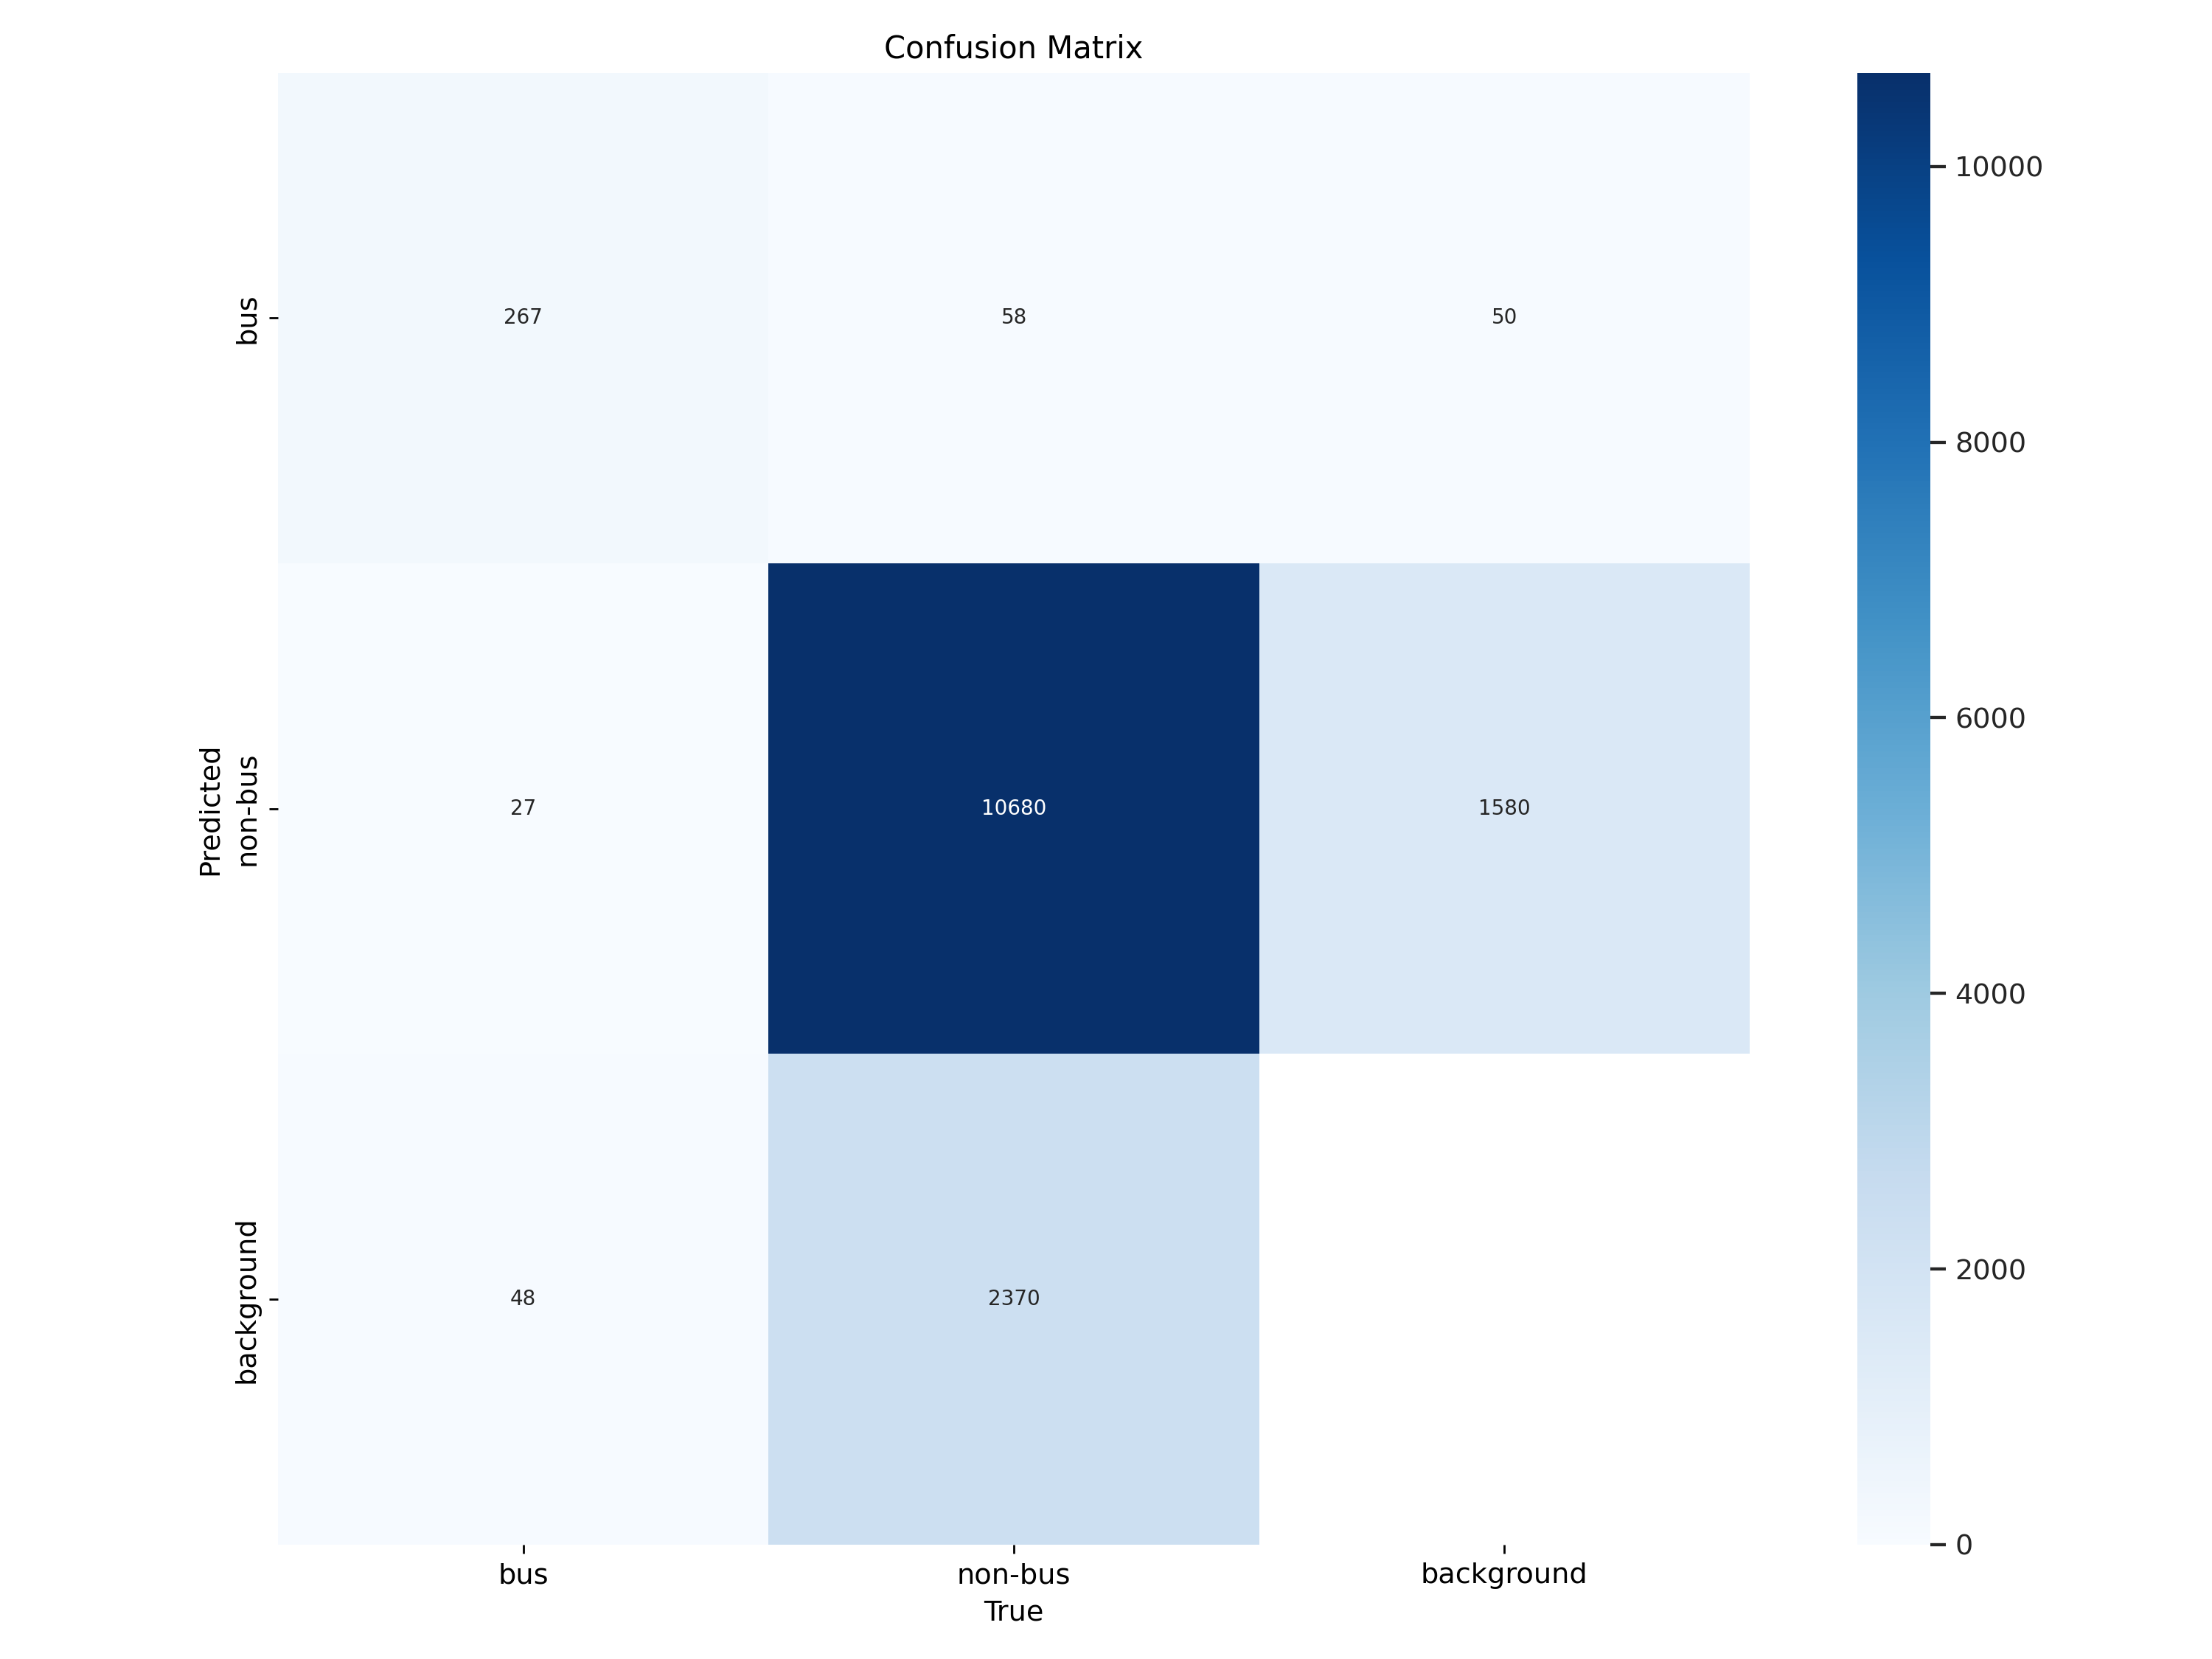

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

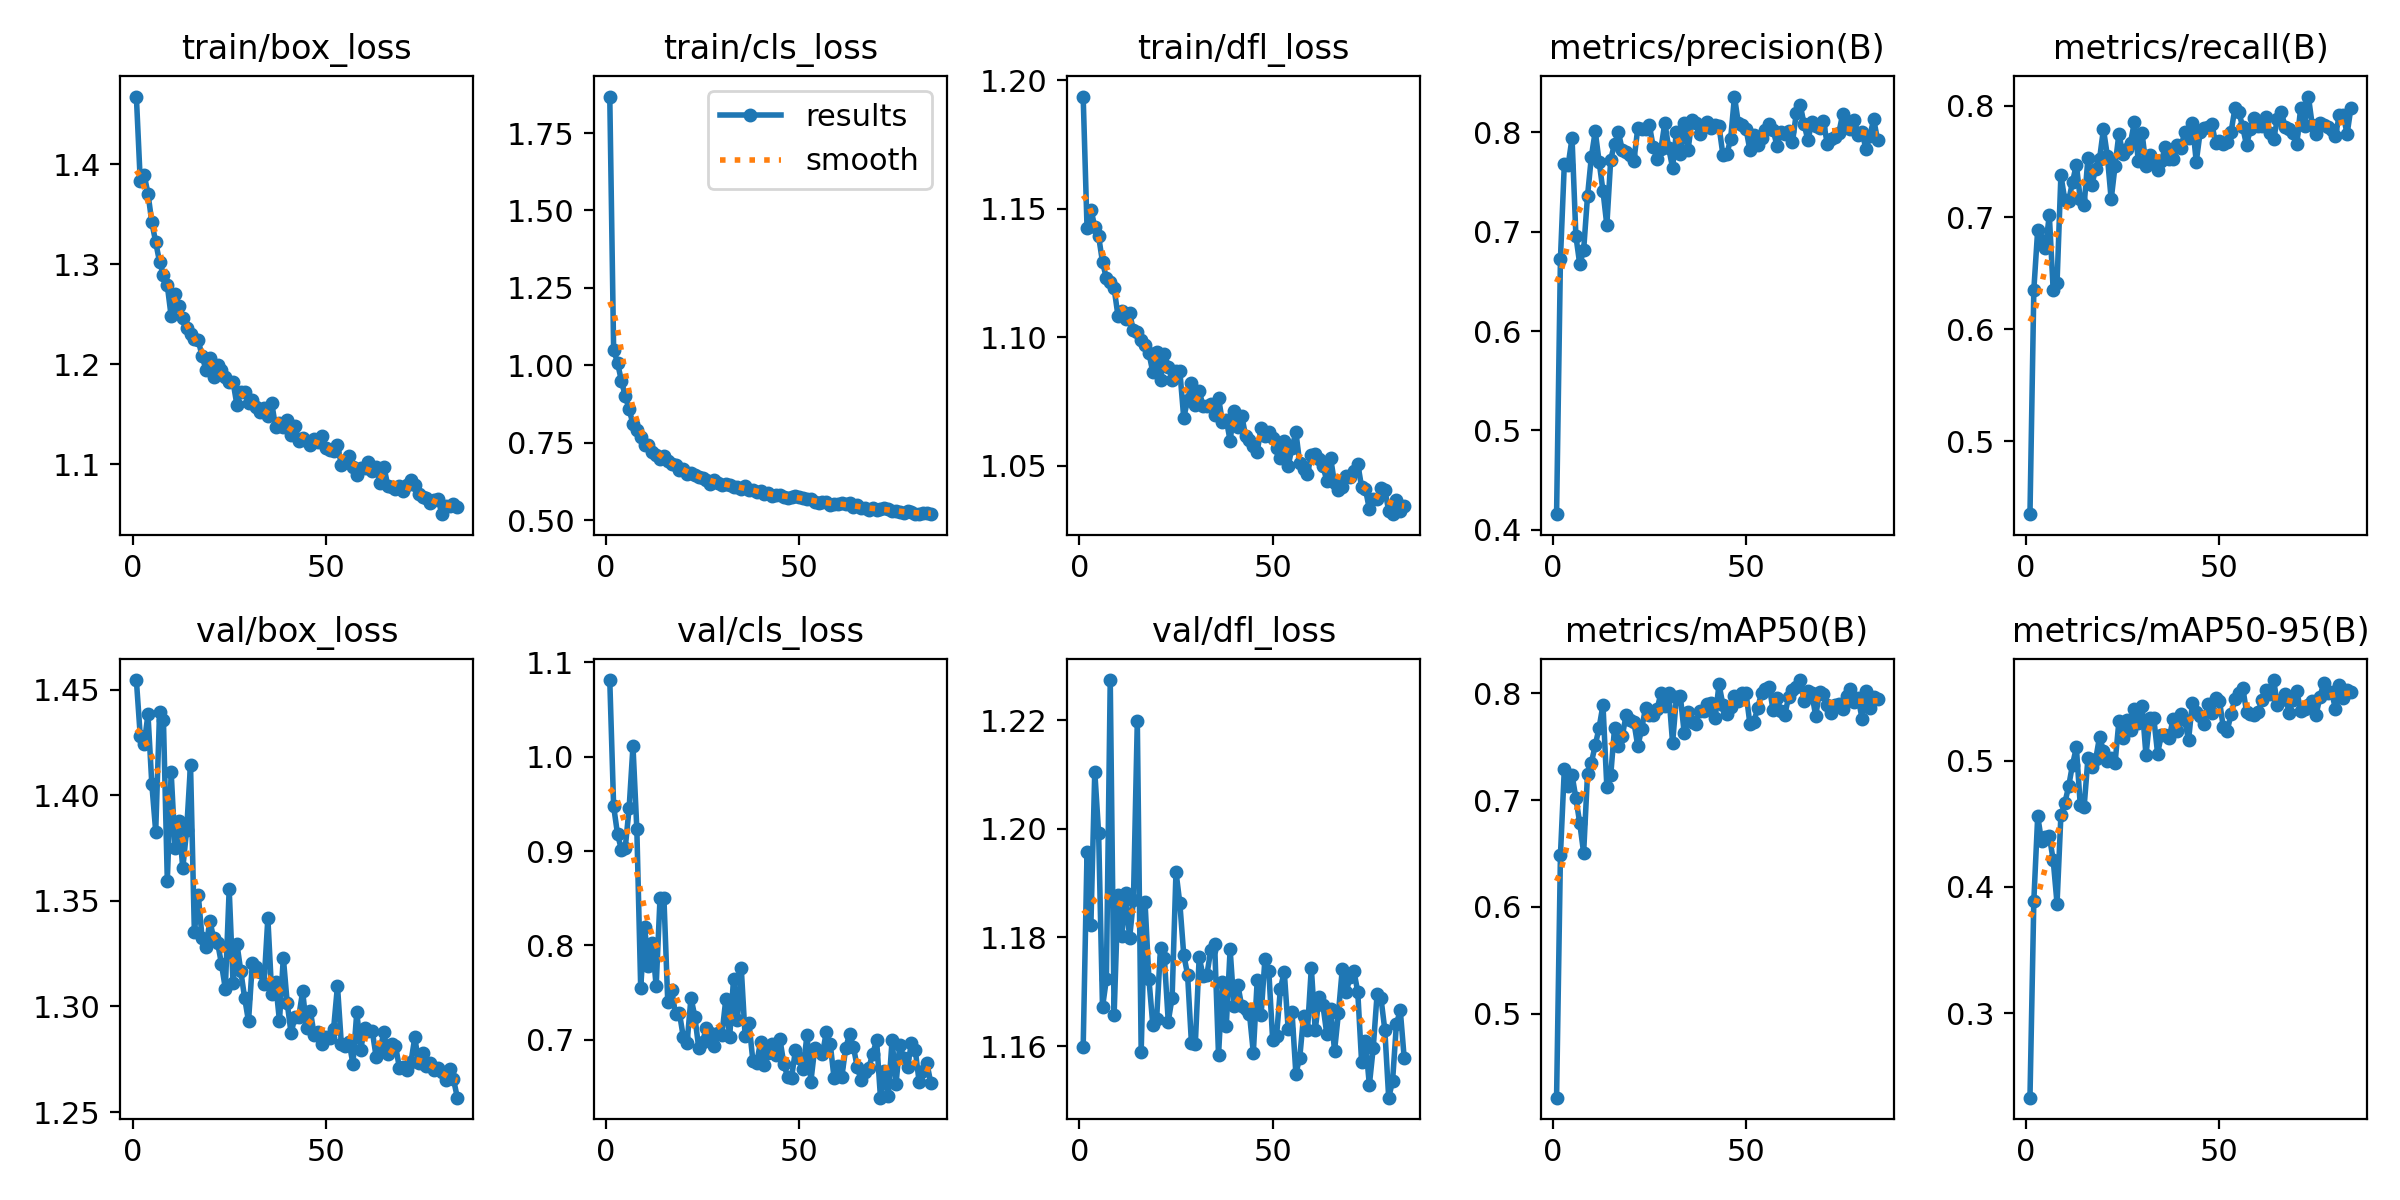

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['bus', 'non-bus']

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.4468750045902752
mAP 50 0.6875047254132877
mAP 75 0.48352203611829997


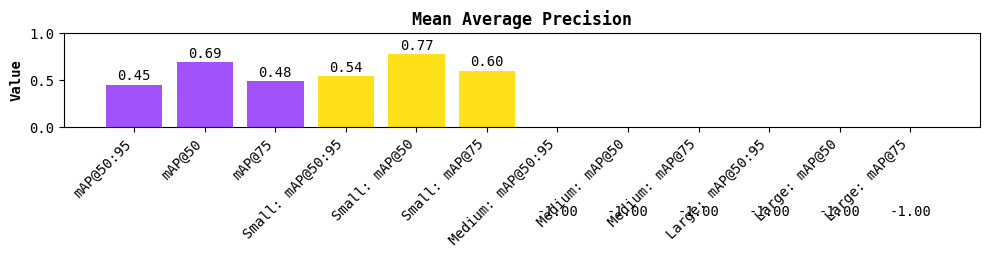

In [18]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [42]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

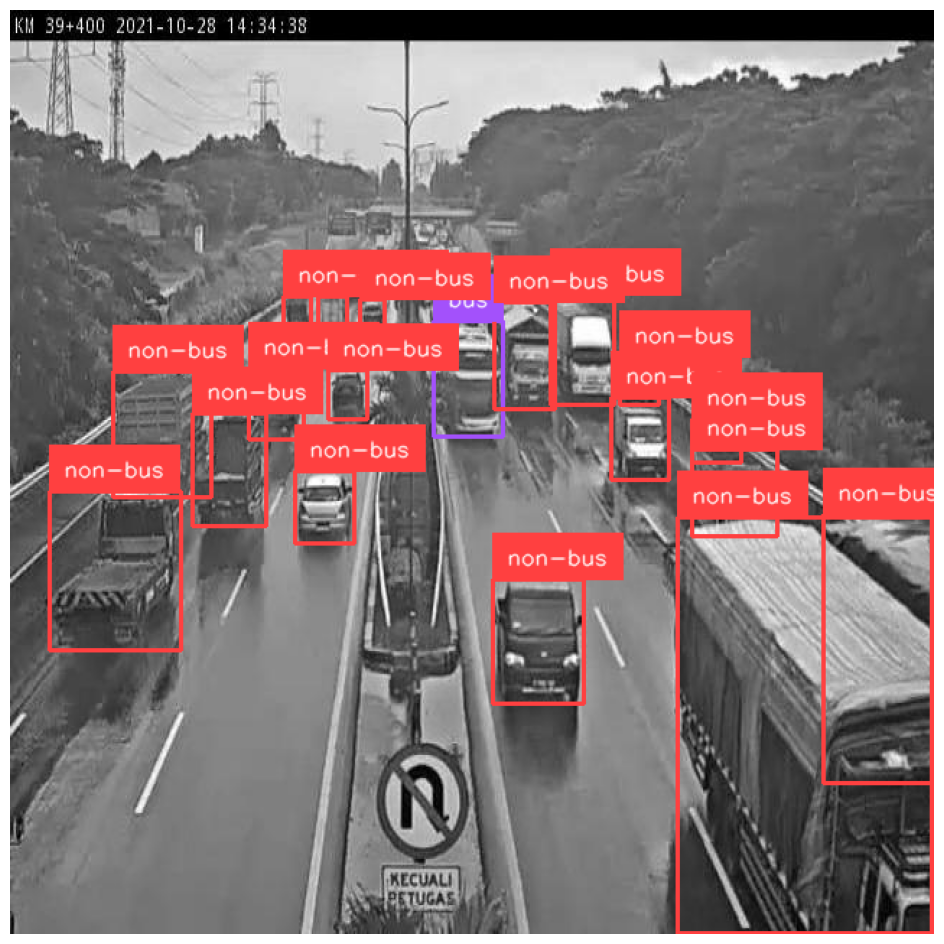

In [43]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

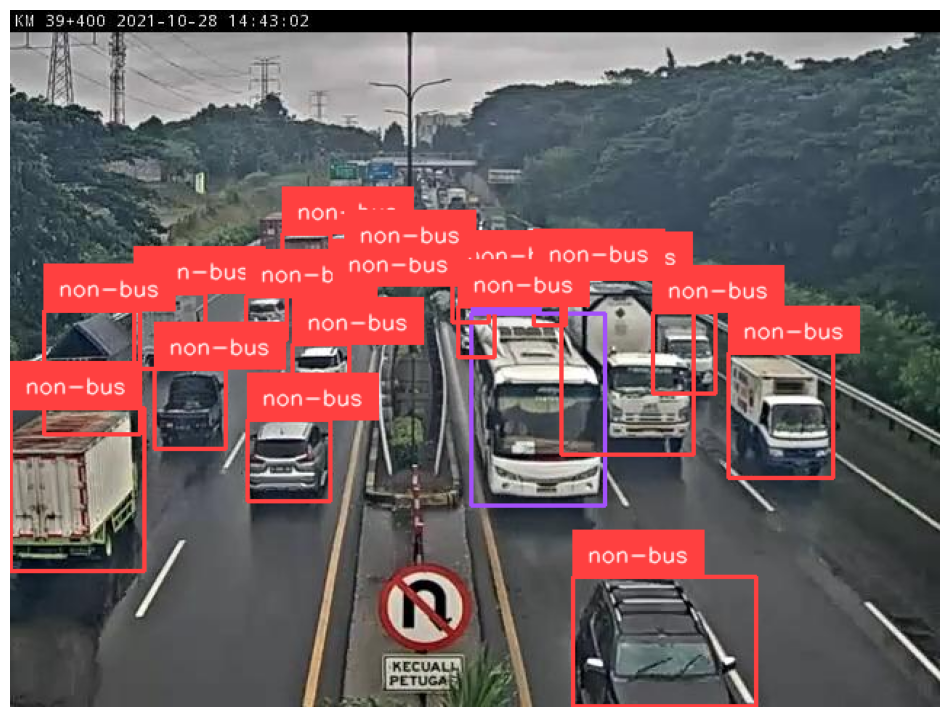

In [44]:
image_path = f"{HOME}/bas.jpg"
image = cv2.imread(image_path)

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

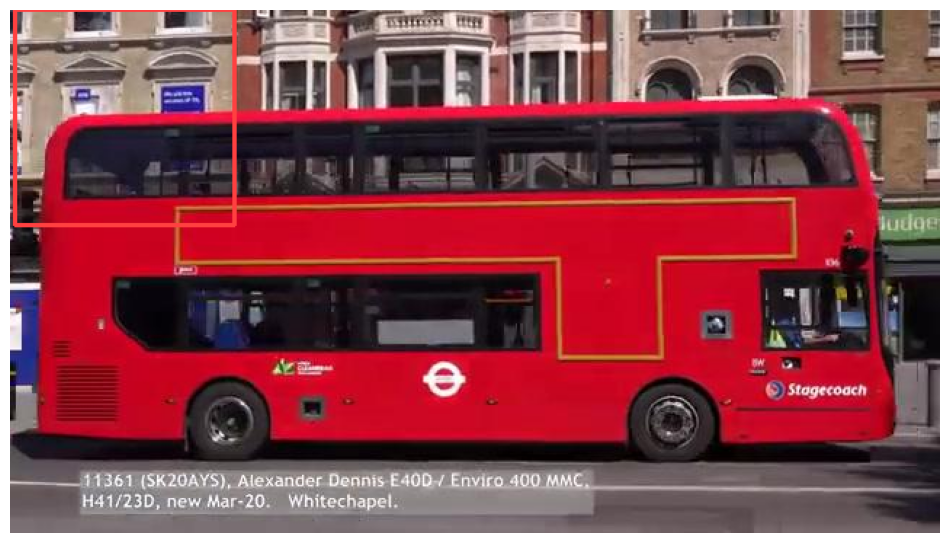

In [45]:
image_path = f"{HOME}/bas2.jpg"
image = cv2.imread(image_path)

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

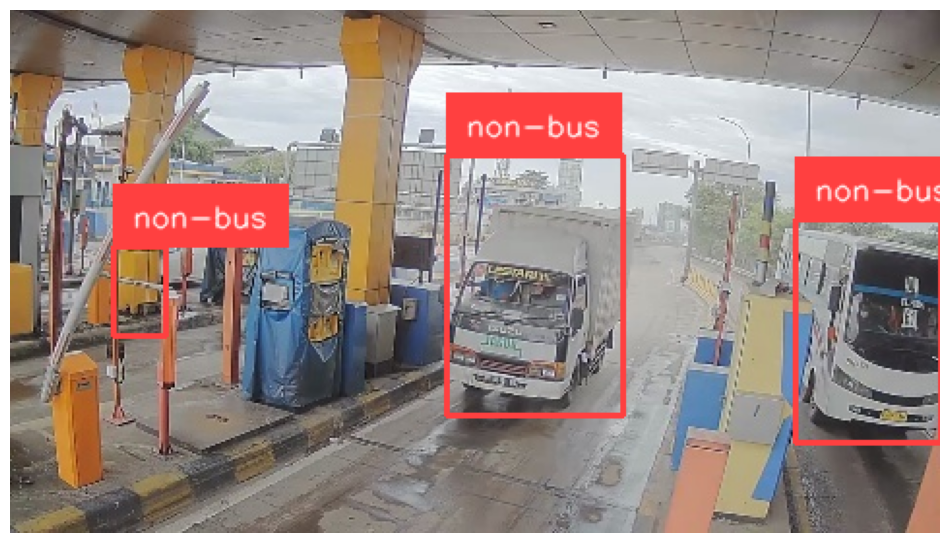

In [46]:
image_path = f"{HOME}/bas3.jpg"
image = cv2.imread(image_path)

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

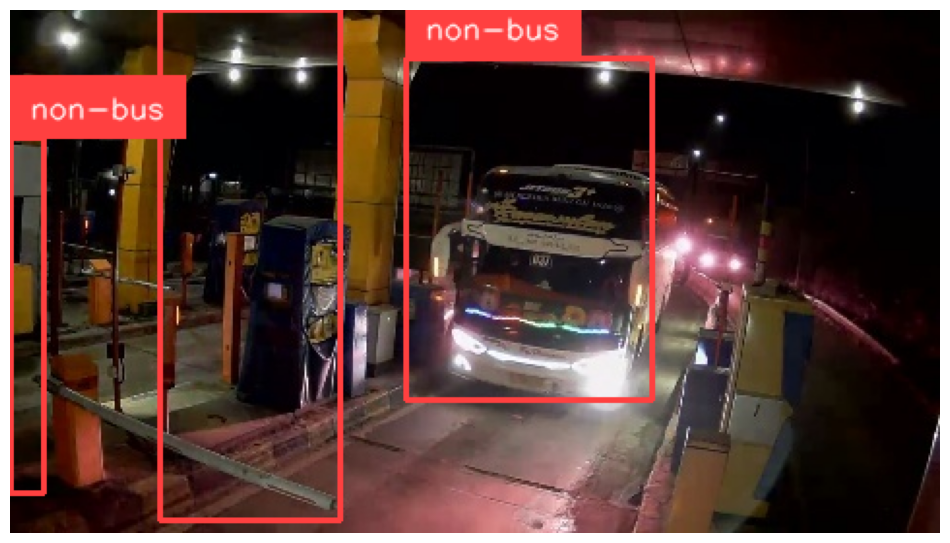

In [47]:
image_path = f"{HOME}/bas4.jpg"
image = cv2.imread(image_path)

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)